In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split ,  GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from copy import deepcopy as dc

In [2]:
data = pd.read_excel('Hang_Seng.xlsx', date_parser = True)

In [3]:
data = data[['Local Time', 'Close']]

In [4]:
data['Local Time'] = pd.to_datetime(data['Local Time'])

In [5]:
def dataframe_transform_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Local Time', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 5
transformdf = dataframe_transform_lstm(data, lookback)
transformdf

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5)
Local Time,,,,,,
2022-06-09 11:45:00,2788.828012,2786.500089,2783.405112,2784.044749,2783.434418,2786.505186
2022-06-09 11:40:00,2785.594149,2788.828012,2786.500089,2783.405112,2784.044749,2783.434418
2022-06-09 11:35:00,2783.041971,2785.594149,2788.828012,2786.500089,2783.405112,2784.044749
2022-06-09 11:30:00,2786.882342,2783.041971,2785.594149,2788.828012,2786.500089,2783.405112
2022-06-09 11:25:00,2785.149461,2786.882342,2783.041971,2785.594149,2788.828012,2786.500089
...,...,...,...,...,...,...
2021-06-10 05:50:00,3727.792740,3715.145033,3716.773836,3718.367847,3715.733928,3719.778875
2021-06-10 05:45:00,3727.924178,3727.792740,3715.145033,3716.773836,3718.367847,3715.733928
2021-06-10 05:40:00,3723.281316,3727.924178,3727.792740,3715.145033,3716.773836,3718.367847


In [6]:
transformdf_np = transformdf.to_numpy()
transformdf_np

array([[2788.82801152, 2786.50008919, 2783.405112  , 2784.04474911,
        2783.43441808, 2786.5051859 ],
       [2785.59414898, 2788.82801152, 2786.50008919, 2783.405112  ,
        2784.04474911, 2783.43441808],
       [2783.04197141, 2785.59414898, 2788.82801152, 2786.50008919,
        2783.405112  , 2784.04474911],
       ...,
       [3723.28131644, 3727.92417819, 3727.79273997, 3715.14503305,
        3716.77383606, 3718.3678466 ],
       [3721.01078567, 3723.28131644, 3727.92417819, 3727.79273997,
        3715.14503305, 3716.77383606],
       [3710.16842132, 3721.01078567, 3723.28131644, 3727.92417819,
        3727.79273997, 3715.14503305]])

In [7]:
scaler = StandardScaler()
transformdf_np = scaler.fit_transform(transformdf_np)

In [8]:
X = transformdf_np[:, 1:]
y = transformdf_np[:, 0]

X.shape, y.shape

((17237, 5), (17237,))

In [9]:
X = dc(np.flip(X, axis=1))
X

array([[-0.96249135, -0.9721804 , -0.97035943, -0.97244723, -0.96286052],
       [-0.97209416, -0.97027195, -0.97235934, -0.96277121, -0.95558321],
       [-0.97018555, -0.97227203, -0.9626825 , -0.95549328, -0.96569258],
       ...,
       [ 1.95160135,  1.94627661,  1.94084445,  1.9800508 ,  1.98012562],
       [ 1.94661661,  1.94118351,  1.98038912,  1.98046173,  1.96561157],
       [ 1.94152307,  1.98073159,  1.98080007,  1.96594646,  1.95851367]])

In [10]:
split_index = int(len(X) * 0.95)

split_index

16375

In [11]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((16375, 5), (862, 5), (16375,), (862,))

In [12]:
svr = SVR()

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1,0.2,1,2,3,4,5,6,7,8,9,10],
    'gamma': ['scale','auto'] + [0.01, 0.1, 1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

In [13]:
best_params = grid_search.best_params_

In [14]:
best_svr = SVR(**best_params)
best_svr.fit(X_train, y_train)

SVR(C=10, gamma=0.01)

In [15]:
y_pred = best_svr.predict(X_test)
y_pred_train=best_svr.predict(X_train)

## Perfomance Metrics of Testing Data

In [16]:
mean_squared_error(y_test, y_pred)

0.0029845649326881627

In [17]:
math.sqrt(mean_squared_error(y_test,y_pred))

0.05463117180409151

In [18]:
r2_score(y_test, y_pred)

0.7359361945834022

## Perfomance Metrics of Training Data

In [19]:
mean_squared_error(y_train, y_pred_train)

0.00046695919657828926

In [20]:
math.sqrt(mean_squared_error(y_train, y_pred_train))

0.021609238685763303

In [21]:
r2_score(y_train, y_pred_train)

0.9994521939514786

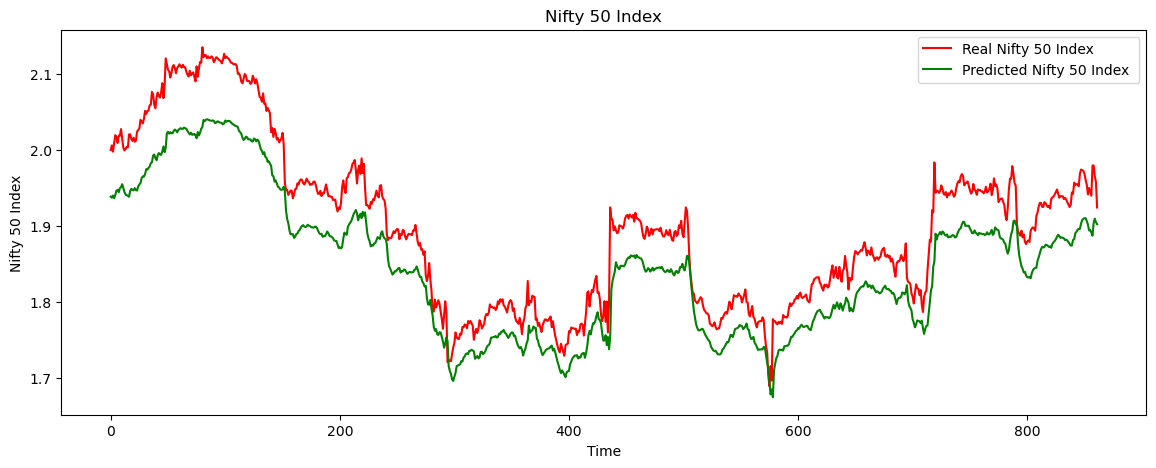

In [22]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Nifty 50 Index ')
plt.plot(y_pred, color = 'green', label = 'Predicted Nifty 50 Index ')
plt.title('Nifty 50 Index')
plt.xlabel('Time')
plt.ylabel('Nifty 50 Index')
plt.legend()
plt.show()